In [1]:
from numpy import linspace
import numpy as np
import scipy
import scipy.optimize
from cmath import *
import mpmath

import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

def get_cmap(N):
    '''Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color.'''
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='hsv') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

# Paramaters calculation

In [27]:
#Defenition of all matrices/params
pi = 3.14159265359
hbar = 1.054e-34
fi_0 = 2.07e-15/2/np.pi

#ALSO - mb add non-Jos inductance?

j_c = 0.4e-6#A/um**2
c_J = 50e-15#F/um**2
area = 20. #um**2

C_J = c_J * area#0.4e-12#0.8e-12
I_J =  j_c * area#8e-6
L_J = fi_0 / I_J
E_J = fi_0**2 / L_J
 
N = 300#300#80
    
C_out = 20e-17
C_0 = 5e-15

print(I_J*1e6, 'uA')
print(C_J*1e12, 'pF')
print('C_J/C_0 = ', C_J / C_0)
print('Z_res = ', (L_J / C_0)**.5)
#print(L_J*1e9, 'nH')
print((C_J*L_J)**(-0.5) /6.28e9, 'GHz')
################################

C = []
L = []# ^-1

for i in range(N+1):
    C.append([])
    L.append([])
    for j in range(N+1):
        if ((i==0)&(j==0)):
            #L[i].append(1./L_J) #lambda/2 
            #C[i].append(C_J)    #lambda/2
            L[i].append(2./L_J)
            C[i].append(2*C_J + C_0)
            continue
        
        if ((i==N)&(j==N)):
            L[i].append(1./L_J) #correctr
            C[i].append(C_J + C_out)
            #L[i].append(2./L_J)
            continue
            
        if (i==j):
            L[i].append(2./L_J)
            C[i].append(2*C_J + C_0)
            continue
            
        if ((j==i+1)or(j==i-1)):
            L[i].append(-1./L_J)
            C[i].append(-C_J)
            continue
        L[i].append(0.)
        C[i].append(0.)

L = np.array(L)
C_inv = scipy.linalg.inv(np.array(C))

8.0 uA
1.0 pF
C_J/C_0 =  200.0
Z_res =  90.75388864949856
24.813619093041716 GHz


In [28]:
C_inv_sqrt= np.mat(scipy.linalg.sqrtm(C_inv))
L_m = np.mat(L)

A=C_inv_sqrt*L*C_inv_sqrt

(freqs,psi) = scipy.linalg.eigh(A,overwrite_a=True)

mode = np.sqrt(freqs)
nums = linspace(1,N+1, N + 1)

plt.plot(nums,(mode)/2/np.pi/1e9,'ro')
plt.xlim(0,10)
plt.show()

In [ ]:
modeNumber = 3

def Phi(k):#Correct??????
    return(C_inv_sqrt*psi *np.sqrt(hbar)/mode[k]**0.5)


psi_norm = C_inv_sqrt* psi 

psi_arr = np.array(psi.T)


phase_norm_luca = np.array((psi_norm * ((2*np.pi)/fi_0)*np.sqrt(hbar)/2/np.array(mode)**0.5).T) #Luca's numbers

phase_norm_quanta = np.array((psi_norm * ((2*np.pi)*fi_0)**-1 *np.sqrt(hbar)/2/np.array(mode)**0.5).T)

plt.plot(nums,(phase_norm_quanta[modeNumber]),'ro', label = 'F/F_0')
#plt.plot(nums,(phase_norm_luca[modeNumber]),'ro', label = 'Luca')

plt.legend(loc = 'best')
#plt.plot(nums,psi_arr[0],'ro')
plt.show()
#print freqs[]**0.5/6.28e9

## Kerr coeffs

In [ ]:
alpha =  - 0.5* hbar/(24. * L_J * fi_0**2) 

bla = np.array(C_inv_sqrt)

def eta_inside(x,j):
    A=bla[x+1]
    B=bla[x]
    C=np.array(psi_arr)[j]
    D=np.sqrt(C_J)*(A-B)*C
    return np.sum(D)


def eta(j,k,l,m):
    A=[eta_inside(x,j) * eta_inside(x,k) * eta_inside(x,l) * eta_inside(x,m) for x in range(N)]
    return np.sum(A)


def beta(j,k,l,m):
    return(-np.abs(alpha *eta(j,k,l,m) / np.sqrt(mode[j]) / np.sqrt(mode[k]) / np.sqrt(mode[l])/ np.sqrt(mode[m])/ C_J**2))

In [ ]:
idler_mode = 7
signal_mode = 8

s = signal_mode
i = idler_mode

K_ssss = beta(s,s,s,s)
K_iiii = beta(i,i,i,i)


print(K_ssss/1e3, K_iiii/1e3)

## ABCD 4 coupling

In [30]:
#functions

def A_J(w):
    a = np.zeros((2,2),dtype = complex)
    a[0][0] = 1.
    a[1][1] = 1.
    a[0][1] = 1./(-1j/w/L_J + 1j*w*C_J)
    return(a)

def A_C(w):
    a = np.zeros((2,2),dtype = complex)
    a[0][0] = 1.
    a[1][1] = 1.
    a[1][0] = (1j*w*C_0)
    return(a)
    
def A_C_out(w):
    a = np.zeros((2,2),dtype = complex)
    a[0][0] = 1.
    a[1][1] = 1.
    a[0][1] = 1/(1j*w*C_out)
    return(a)

def A(w):
    A_0 = np.dot(A_C(w),A_J(w))
    A = A_J(w)
    for k in range(N - 1):
        A = np.dot(A,A_0)
        
    A = np.dot(A, A_C_out(w))
    return(A)

def S(w):#linspace at the input
    S = []
    for k in range(len(w)):
        #print(A(w[k]))
        bla = A(w[k])
        buf = (bla[0][0] - bla[1][0]*50. + bla[0][1]/50. - bla[1][1])/(bla[0][0] + bla[1][0]*50. + bla[0][1]/50. + bla[1][1])
        
        S.append(buf)
    return(S)

In [31]:
w_start = 6.28e9 * .5
w_stop = 6.28e9 * 20.
w_len = 5e4

w = linspace(w_start, w_stop, w_len)

buf = S(w)
buf1 = 20* np.log10(np.abs(buf))

In [34]:
phases = []
for k in range(len(buf)):
    phases.append((phase(buf[k])))
    
plt.plot(w/6.29e9, (phases))
plt.show()

In [33]:
reals = []
imags = []
for k in range(len(buf)):
    reals.append((buf[k].real))
    imags.append((buf[k].imag))
    
plt.plot(w/6.29e9, reals)
plt.plot(w/6.29e9, imags)
plt.show()

# Eichler model

In [43]:
#parameters
z = 2e9*np.pi

w_l = 8.6 * 2e9 * np.pi
w_r = 8.6 * 2e9 * np.pi

kappa = 600*6.28e6#290 * 2e6*np.pi
gamma = 0. * 2e6*np.pi
J =     .7*kappa

U_l = -80e3
U_r = U_l

## Weak signal regime

In [45]:
def weakProbe(w):
    buf = -1. - 1j* kappa * (w - w_r + 0.5j * gamma) / (J**2 - (w - w_r + 0.5j * gamma) * (0.5j*kappa + w - w_l) )
    #return(20* np.log10(np.abs(buf)))
    return((buf))

w_probe = linspace(6*6.28e9, 10* 6.28e9, 1e5)

#plt.plot(w_probe/2e9/np.pi, (np.abs(weakProbe(w_probe))),'r')
plt.plot(w_probe/2e9/np.pi, weakProbe(w_probe).real,'r')
plt.plot(w_probe/2e9/np.pi, weakProbe(w_probe).imag,'g')
plt.axvline(w_l/z)
plt.axvline(w_r/z)
plt.show()

## Pump responce 

In [46]:
def getPumpAlpha(alpha_in, w_p): #Problem is here. TOO sensitive to initial guess
    def function(x_in):
        a,b,c,d = x_in
        x = a + 1j*b
        y = c + 1j*d
        fun_l = 1j * (w_p - w_l)*x - 0.5*kappa * x  - .5j * J * y - 1j*U_l * np.abs(x)**2 * x + (kappa**.5) * alpha_in
        fun_r = 1j * (w_p - w_r)*y - .5j*J*x - 1j*U_r* np.abs(y)**2 * y
        return(fun_l.real, fun_l.imag, fun_r.real, fun_r.imag)
    return(scipy.optimize.root(function, (15.,10.,15.,10.)).x)

def Alphas(alpha_in, w_p):
    x = getPumpAlpha(alpha_in, w_p)
    return( (x[0] + 1j*x[1]), (x[2] + 1j*x[3]) )

In [48]:
#When it is bifurcating, solution is a piece of ****.
#But I won't go into this regime, so I don't care. Pre-Bifurc seems to be ok.

freq_min = w_r - 3*kappa
freq_max = w_l + 3*kappa
freq_num = 1e3

midFreq = (w_l + w_r)/2.

alpha_min = 2e6
alpha_max = 5e6
alpha_num = 5

k = 0
cmap = get_cmap(alpha_num)

for alpha_in in linspace(alpha_min, alpha_max, alpha_num):
    left = []
    right = []
    for f_p in linspace(freq_min, freq_max, freq_num):
        x = getPumpAlpha(alpha_in, f_p)
        left.append(abs((x[0] + 1j*x[1])))
        right.append(abs((x[2] + 1j*x[3])))

    bufer = np.array(left)
    bufer1 = np.array(right)
    f_p = linspace(freq_min, freq_max, freq_num)
    #plt.plot( (f_p - midFreq)/kappa, bufer, label = str(alpha_in) )
    plt.plot( (f_p - midFreq)/kappa , bufer, label = str(alpha_in), color = cmap(k) )
    plt.plot( (f_p - midFreq)/kappa , bufer1, label = str(alpha_in), color = cmap(k), linestyle = ':', markersize=10 )
    k = k+1
    
# plt.axvline((midFreq - .6*kappa)/6.28e9)
    
plt.show()

# Gain

In [49]:
# phase(alpha) = 0
def S(w, alphas, w_p):#vetor - bl(w), bl^+(w_p - w), br(w), br+(w_p - w)
    alpha_l, alpha_r = alphas
    M = np.zeros((4,4),dtype=complex)
    M[0,0] = 1j*(w - w_l - 2.*U_l*abs(alpha_l)**2 + 0j) - 0.5*kappa
    M[0,1] = -1j*(0j+U_l * alpha_l**2)
    M[0,2] = -1j*J
    
#     M[1,0] = M[0,1].conjugate()
#     M[1,1] = M[0,0].conjugate()
#     M[1,3] = M[0,2].conjugate()
    M[1,0] = 1j * (U_l * alpha_l.conjugate()**2)
    M[1,1] = -0.5*kappa - 1j*( 2*w_p - w - w_l - 2.*U_l*abs(alpha_l)**2 )
    M[1,3] = 1j*J
    
    
    M[2,0] = -1j*J
    M[2,2] = 1j*(w - w_r - 2*U_r*abs(alpha_r)**2)
    M[2,3] = -1j*U_r*alpha_r**2
    
    M[3,1] = 1j*J
    M[3,2] = M[2,3].conjugate()
    M[3,3] = -1j*(2*w_p - w - w_r - 2*U_r*abs(alpha_r)**2)
    
    return M

def S_noW(w, alphas, w_p):#vetor - bl(w), bl^+(w_p - w), br(w), br+(w_p - w)
    alpha_l, alpha_r = alphas
    M = np.zeros((4,4),dtype=complex)
    M[0,0] = 1j*( - w_l - 2.*U_l*abs(alpha_l)**2 + 0j) - 0.5*kappa
    M[0,1] = -1j*(0j+U_l * alpha_l**2)
    M[0,2] = -1j*J
    
#     M[1,0] = M[0,1].conjugate()
#     M[1,1] = M[0,0].conjugate()
#     M[1,3] = M[0,2].conjugate()
    M[1,0] = 1j * (U_l * alpha_l.conjugate()**2)
    M[1,1] = -0.5*kappa - 1j*(  - w_l - 2.*U_l*abs(alpha_l)**2 )
    M[1,3] = 1j*J
    
    
    M[2,0] = -1j*J
    M[2,2] = 1j*( - w_r - 2*U_r*abs(alpha_r)**2)
    M[2,3] = -1j*U_r*alpha_r**2
    
    M[3,1] = 1j*J
    M[3,2] = M[2,3].conjugate()
    M[3,3] = -1j*( - w_r - 2*U_r*abs(alpha_r)**2)
    
    return M

def Gains(w, alpha_in, w_p):
    g_s = []
    g_i = []
    alphas = Alphas(alpha_in,w_p)
    for k in range(len(w)):
        f = w[k]
        M = S(f, alphas, w_p)
        b = np.zeros(4, dtype=complex)
        b_in = np.array([1. + 0j,0.,0.,0.])
        b_in_i = np.array([0. + 0j,1.,0.,0.])
        
        b_s = np.dot(np.linalg.inv(M), b_in)
        b_i = np.dot(np.linalg.inv(M), b_in_i)
        g_s.append( - kappa*b_s[0] - 1. + 0j)#-kappa!!
        g_i.append(- kappa*b_i[0])#-kappa!!!!
    return(g_s, g_i)

def Gain_sig_dB(w, alpha_in, w_p):
    return(20 * np.log10(np.abs(Gains(w, alpha_in, w_p)[0])))

def Gain_idl_dB(w, alpha_in, w_p):
    return(20 * np.log10(np.abs(Gains(w, alpha_in, w_p)[1])))

def Stability(w, alphas, w_p):
    M = S_noW(w, alphas, w_p)
    (vals,psi) = scipy.linalg.eig(M,overwrite_a=True)
    return(vals)

In [50]:
Stability(w_l, Alphas(1e9,midFreq - 2*kappa),midFreq - 2*kappa) #WTF?

array([ -1.60535401e+09 -4.66992553e+10j,
        -2.78645992e+08 -5.38905896e+10j,
        -1.60535401e+09 +4.66992553e+10j,  -2.78645992e+08 +5.38905896e+10j])

In [53]:
freq_min = midFreq - 2*kappa#w_l - 2*kappa
freq_max = midFreq + 1*kappa#w_r + 2*kappa
freq_num = 3e1

#alpha_min = .6e6
#alpha_max = 5e6
#alpha_num = 10e0

w = linspace(w_l - 5*kappa, w_r + 5*kappa, 1e3)

gains = []

k = 0
pump_powers = linspace(alpha_min,alpha_max,alpha_num)
pump_freqs = linspace(freq_min, freq_max, freq_num)

# for alpha_in in linspace(alpha_min,alpha_max,alpha_num):
#     gains.append([])
#     for w_p in linspace(freq_min, freq_max, freq_num):
#         gains[k].append(np.max(Gain_sig_dB(w,alpha_in,w_p)))
#     k = k+1

alpha_in = 1.2*alpha_max#3.2e6

for w_p in linspace(freq_min, freq_max, freq_num):
    gains.append((Gain_sig_dB(w,alpha_in,w_p)))

In [54]:
#plt.pcolor((pump_freqs - midFreq)/kappa, pump_powers, np.array(gains))
plt.pcolor( w/6.28e9,(pump_freqs - midFreq)/kappa, np.array(gains))
plt.colorbar()

plt.show()

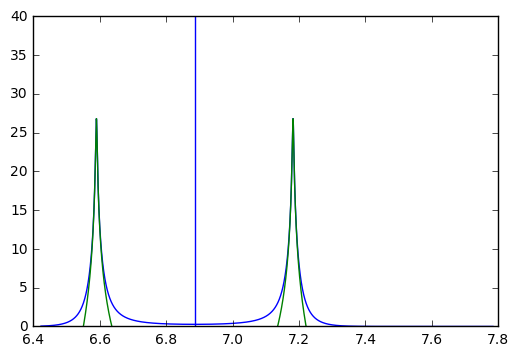

In [63]:
alpha_in = 4.3e6
w_p = midFreq - .75*kappa

w = linspace(w_r - 2*kappa, w_l + 2*kappa, 1e4)
plt.plot(w/6.28e9, Gain_sig_dB(w,alpha_in,w_p))
plt.plot(w/6.28e9, Gain_idl_dB(w,alpha_in,w_p))
plt.axvline(w_p/6.28e9)
plt.ylim(0,)
#plt.plot(w/6.28e9, Gain_sig_dB(w,5e5,.5*(7.41 + 7.8)*6.28e9))
plt.show()

In [98]:
buf = Gains(w,4e6,midFreq - 0.6*kappa)
Diff = abs(np.array(buf[0]))**2 - abs(np.array(buf[1]))**2
plt.plot(w,Diff)
plt.show()

In [300]:
N  = 400.
n = linspace(1,N, N)

plt.plot(n, np.log10(1/(n)),'b', label = 'Lumped-element')
plt.plot(n, np.log10(1/(2.*n**2/3./np.pi**4)), 'r', label = 'Distributed')
plt.legend(loc ='best')
plt.xlabel('Number of SQUIDs')
plt.ylabel('log10(K)')
plt.show()

In [28]:
getPumpAlpha(4e5, midFreq - .62*kappa).x

array([ 18.21352721,  -3.10058999, -36.53920439,   6.22027189])

In [89]:
(4e6)**2 * U_l / kappa**2

-0.3855265013739368